In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import preprocessing
from keras.utils import plot_model


# directories
stat_data_dir = 'E:/stat_data'
name_simple_stat = 'simple_stat.csv'
name_split_up_stat = 'split_up_stat.csv'
name_quality_data = 'quality_data.csv'
name_figures_dir = 'E:/figures'

# Parameters
test_size = 0.1 # how much of the data will be used as test set
val_size = 0.2 # how much of the data will be used as validation set
save_fig = False # set True or False to save figures and R2 scores.csv to figures_dir 
save_model_fig = False
saving_addendum = '' # append an addendum to the file name


# load the data
# drop columns without relevant data
drop_cols = ['Unnamed: 0', 'breakout_in', 'breakout_out', 'burr_height_in']
qual_data = pd.read_csv(stat_data_dir +'//'+ name_quality_data).drop(drop_cols, axis=1)
simple_stat_data = pd.read_csv(stat_data_dir +'//'+ name_simple_stat)
split_up_stat_data = pd.read_csv(stat_data_dir +'//'+ name_split_up_stat)

# join the dataframes and eliminate drill holes without quality data
sstData_all = pd.merge(simple_stat_data, qual_data, on='borehole_id')
splData_all = pd.merge(split_up_stat_data, qual_data, on='borehole_id')


# drop drill holes without quality data
# drop all drill holes with any nan values
sstData = sstData_all.dropna(thresh=5)\
  .dropna(subset=['mean','stddev']).dropna() # thresh indicates minimum number of entries that are not NaN
splData = splData_all.dropna(thresh=9)\
  .dropna(subset=['borehole_id','mean_entry','stddev_entry','mean_main','stddev_main','mean_end','stddev_end']).dropna()


# convert to arrays, column names saved as list
sst_array = sstData.to_numpy()
sst_cols = list(sstData.columns.values)
spl_array = splData.to_numpy()
spl_cols = list(splData.columns.values)


# shuffle and split into training, validation and test dataset and into input and regressor variables
np.random.seed(6)
np.random.shuffle(sst_array)
np.random.shuffle(spl_array)
Xsst_train, Xsst_tstval, ysst_train, ysst_tstval\
    = train_test_split(np.float32(sst_array[:,1:3]), np.float32(sst_array[:,3:]), test_size=(val_size+test_size), shuffle=False)
Xsst_test, Xsst_val, ysst_test, ysst_val\
    = train_test_split(Xsst_tstval, ysst_tstval, test_size=val_size/(val_size+test_size), shuffle=False)
Xspl_train, Xspl_tstval, yspl_train, yspl_tstval\
    = train_test_split(np.float32(spl_array[:,1:7]), np.float32(spl_array[:,7:]), test_size=(val_size+test_size), shuffle=False)
Xspl_test, Xspl_val, yspl_test, yspl_val\
    = train_test_split(Xspl_tstval, yspl_tstval, test_size=val_size/(val_size+test_size), shuffle=False)


# normalize coloumwise
# simple standardized data
scaler_Xsst = preprocessing.StandardScaler().fit(Xsst_train)
Xsst_train = scaler_Xsst.transform(Xsst_train)
Xsst_val = scaler_Xsst.transform(Xsst_val)
Xsst_test = scaler_Xsst.transform(Xsst_test)

scaler_ysst = preprocessing.StandardScaler().fit(ysst_train)
ysst_train = scaler_ysst.transform(ysst_train)
ysst_val = scaler_ysst.transform(ysst_val)
ysst_test = scaler_ysst.transform(ysst_test)


# for the split up data
scaler_Xspl = preprocessing.StandardScaler().fit(Xspl_train)
Xspl_train = scaler_Xspl.transform(Xspl_train)
Xspl_val = scaler_Xspl.transform(Xspl_val)
Xspl_test = scaler_Xspl.transform(Xspl_test)

scaler_yspl = preprocessing.StandardScaler().fit(yspl_train)
yspl_train = scaler_yspl.transform(yspl_train)
yspl_val = scaler_yspl.transform(yspl_val)
yspl_test = scaler_yspl.transform(yspl_test)


# define functions
# function to reverse the scaling of the output parameters after the NN computation
def rev_scaling(scaler_labels, out_arr):
    # takes the normalized y values predicted by the NN and calculates the real quality data based on them
    # formula normalized_y = (y-mean)/std ==> normalized_y*std + mean = y
    mean_arr = scaler_labels.mean_
    std_arr = (scaler_labels.var_)**0.5
    qual_pred = np.multiply(out_arr, std_arr) + np.multiply(np.ones(np.shape(out_arr)), mean_arr)
    return qual_pred



In [8]:
# visualize mean squared error
def plot_history(history, stat_type):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    plt.legend()
    plt.ylim([0.5,1])
    if save_fig==True:
        plt.savefig(name_figures_dir +'//'+ 'MAE_' + stat_type +'.png', dpi=400)
        print ('saved to: %s' % name_figures_dir)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val Error')
    plt.legend()
    plt.ylim([0.5,1])
    if save_fig==True:
        plt.savefig(name_figures_dir +'//'+ 'MSE_' + stat_type +'.png', dpi=400)
        print ('saved to: %s' % name_figures_dir)
    return None


# plot pred y_val over real y_val for all labels of a borehole
def plot_labels(stat_array, real_y, pred_y, stat_type):
    num_labels = np.shape(real_y)[1]
    label_names_old = sst_cols[-num_labels:]
    label_names = []
    for title in label_names_old:
        string = title.replace('_', ' ').capitalize().replace('ra', '$R_a$').replace('rz', '$R_z$')
        if ('Roughness' in string) or ('Roundness' in string):
            string = string + ' in $\mu$m'
        elif ('Burr' in string) or ('Diameter' in string):
            string = string + ' in mm'
        label_names.append(string)
    num_cols = 3
    num_rows = -(-num_labels // num_cols)
    fig = plt.figure(figsize=(12,15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(1, num_labels+1):
        ax = fig.add_subplot(num_rows, num_cols, i)
        ax.scatter(real_y[:,i-1], pred_y[:,i-1])
        ax.plot([-1000,1000],[-1000,1000], 'red')
        ax.axis('equal')
        all_y = np.concatenate((real_y[:,i-1], pred_y[:,i-1]), axis=None)
        y_lower = np.amin(all_y)
        y_upper = np.amax(all_y)
        ax.set_xlim([y_lower, y_upper])
        ax.set_ylim([y_lower, y_upper])
        ax.set_title('%s' % label_names[i-1])
        ax.set(xlabel='Measured', ylabel='Predicted')
    plt.tight_layout()
    if save_fig==True:
        plt.savefig(name_figures_dir +'//'+ 'scatter_' + stat_type +'.png', dpi=400)
        print ('saved to: %s' % name_figures_dir)
    plt.show()
    return None

    
# create boxplots that visualize the deviation in percentille groups
def hist_accuracy(stat_array, real_y, pred_y, stat_type):
    num_labels = np.shape(real_y)[1]
    label_names_old = sst_cols[-num_labels:]
    label_names = []
    for title in label_names_old:
        string = title.replace('_', ' ').capitalize().replace('ra', '$R_a$').replace('rz', '$R_z$')
        label_names.append(string)
    num_cols = 3
    num_rows = -(-num_labels // num_cols)
    deviation = np.true_divide((pred_y - real_y), real_y)*100
    fig = plt.figure(figsize=(12,15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    maxfreq = 0
    for i in range(1, num_labels+1):
        ax = fig.add_subplot(num_rows, num_cols, i)
        n, bins, patches = ax.hist(x=deviation[:,i-1], bins='auto')
        ax.set_title('%s' % label_names[i-1])
        ax.set(xlabel='Deviation [%]', ylabel='Frequency')
    plt.tight_layout()
    if save_fig==True:
        plt.savefig(name_figures_dir +'//'+ 'histogram_' + stat_type +'.png', dpi=400)
        print ('saved to: %s' % name_figures_dir)
    plt.show()
    return None

    
# function to transform tensor to numpy array
def tensor_to_array(tensor):
    sess = tf.keras.backend.get_session()
    array = sess.run(pred)
    return array

    

In [9]:
import pathlib
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.constraints import NonNeg


# design neural network structure for split up and simple stat. data
# Hyperparameters
learningRate = 0.001
num_epochs = 500


# build model
def build_model(train_dataset, labels):
    model = keras.Sequential([
        layers.Dense(32, activation=tf.nn.relu, input_shape=[np.shape(train_dataset)[1]]),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(np.shape(labels)[1])
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(learningRate)

    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    return model



Testing set Mean Square Error: 0.8341819158306828


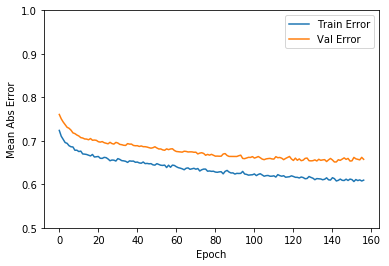

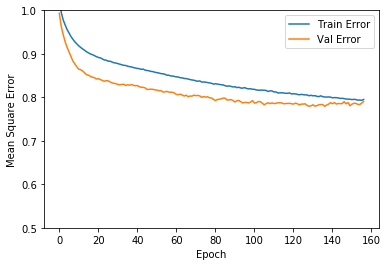

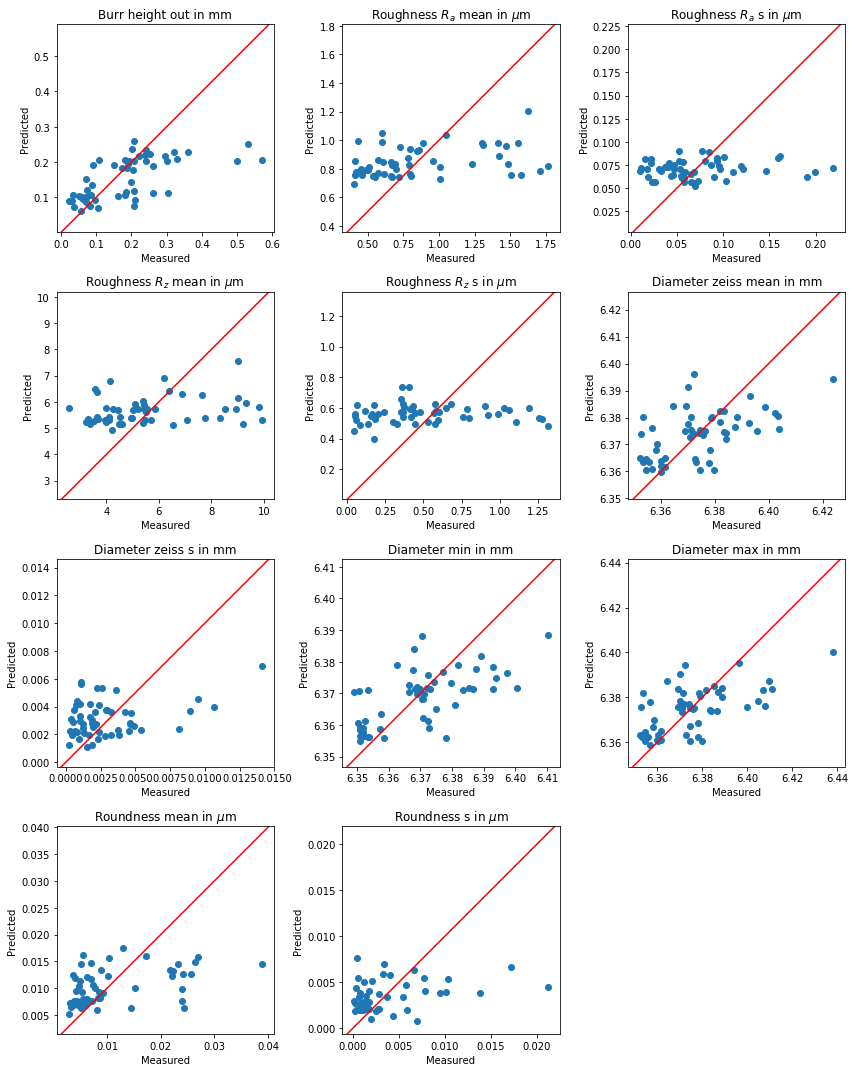

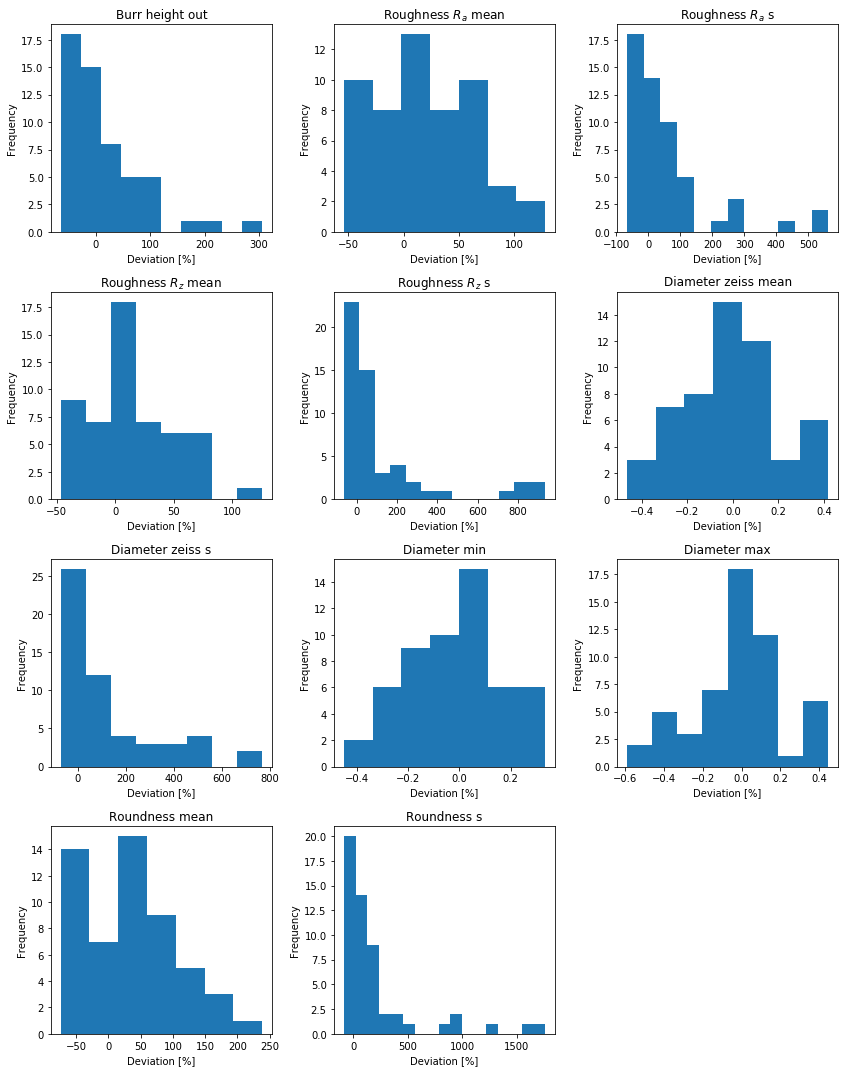

[ 0.32666821  0.11659103 -0.00638673  0.06070511 -0.04443562  0.28697503
  0.08506314  0.38232411  0.33705832  0.19117865  0.11931223]


In [10]:
# for simple statistical data
# create model
model_sst = build_model(Xsst_train, ysst_train)
if save_model_fig==True:
    plot_model(model_sst, to_file='C:/Users/nicol/OneDrive/Dokumente/Universitaet/Bachelorarbeit/novoid-LaTeX-KOMA-template-59a93cd/figures//model_sst.png', show_shapes=True, show_layer_names=True)


# train model
early_stop_sst = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history_sst = model_sst.fit(
    Xsst_train, ysst_train,
    epochs=num_epochs, validation_split = val_size, verbose=0, callbacks=[early_stop_sst])

# record history in a dataframe
hist_sst = pd.DataFrame(history_sst.history)
hist_sst['epoch'] = history_sst.epoch


# plot history
plot_history(history_sst, stat_type='sst'+saving_addendum)


# evaluate on the test set
ysst_pred = model_sst.predict(Xsst_test)


# mse for test set
loss_sst, mae_sst, mse_sst = model_sst.evaluate(Xsst_test, ysst_test, verbose=0)

print("Testing set Mean Square Error: {}".format(mse_sst))


# plot real and predicted labels for simple statistical data
ysst_testnn = rev_scaling(scaler_ysst, ysst_test)
ysst_prednn = rev_scaling(scaler_ysst, ysst_pred)
plot_labels(sst_array, ysst_testnn, ysst_prednn, stat_type='sst'+saving_addendum)


# plot histogram
hist_accuracy(sst_array, ysst_testnn, ysst_prednn, stat_type='sst'+saving_addendum)

# calculate r2 scores
R2_sst = r2_score(y_true=ysst_testnn, y_pred=ysst_prednn, multioutput='raw_values')
print (R2_sst)


Testing set Mean Square Error: 0.7062349407761185


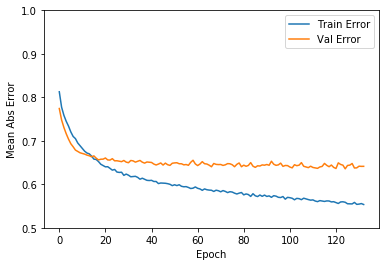

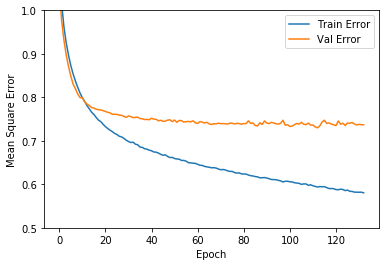

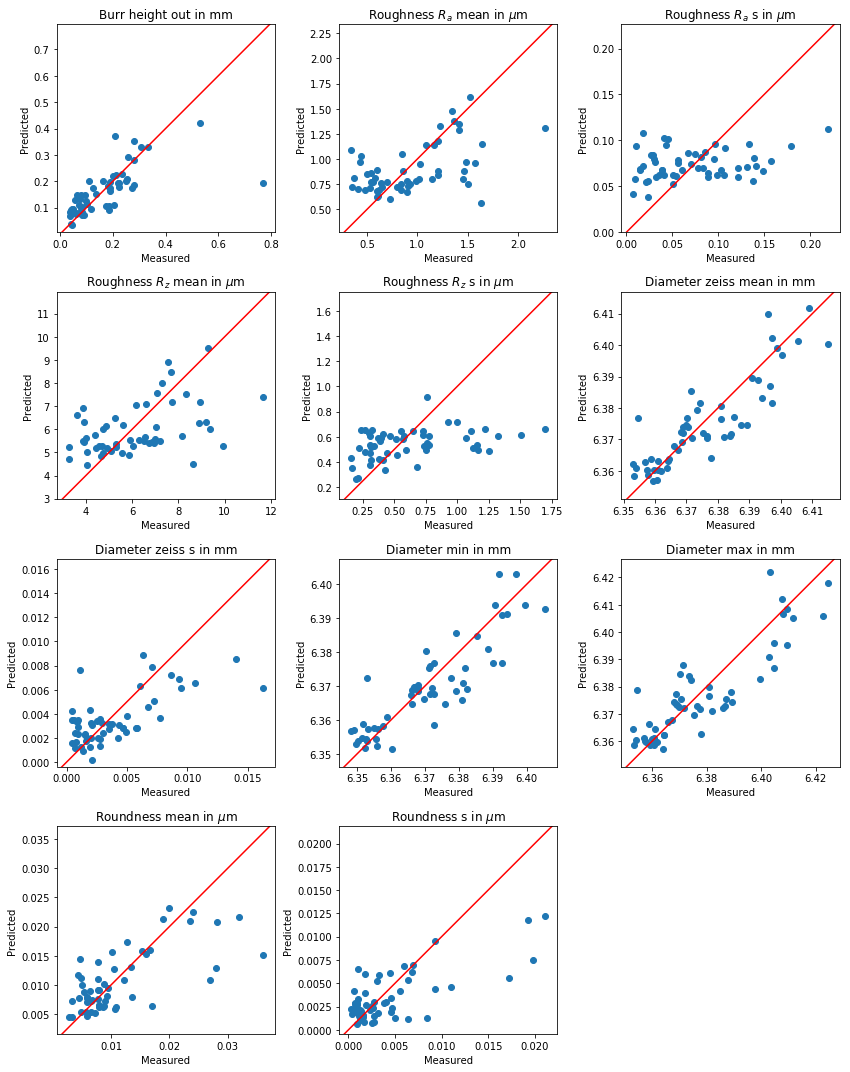

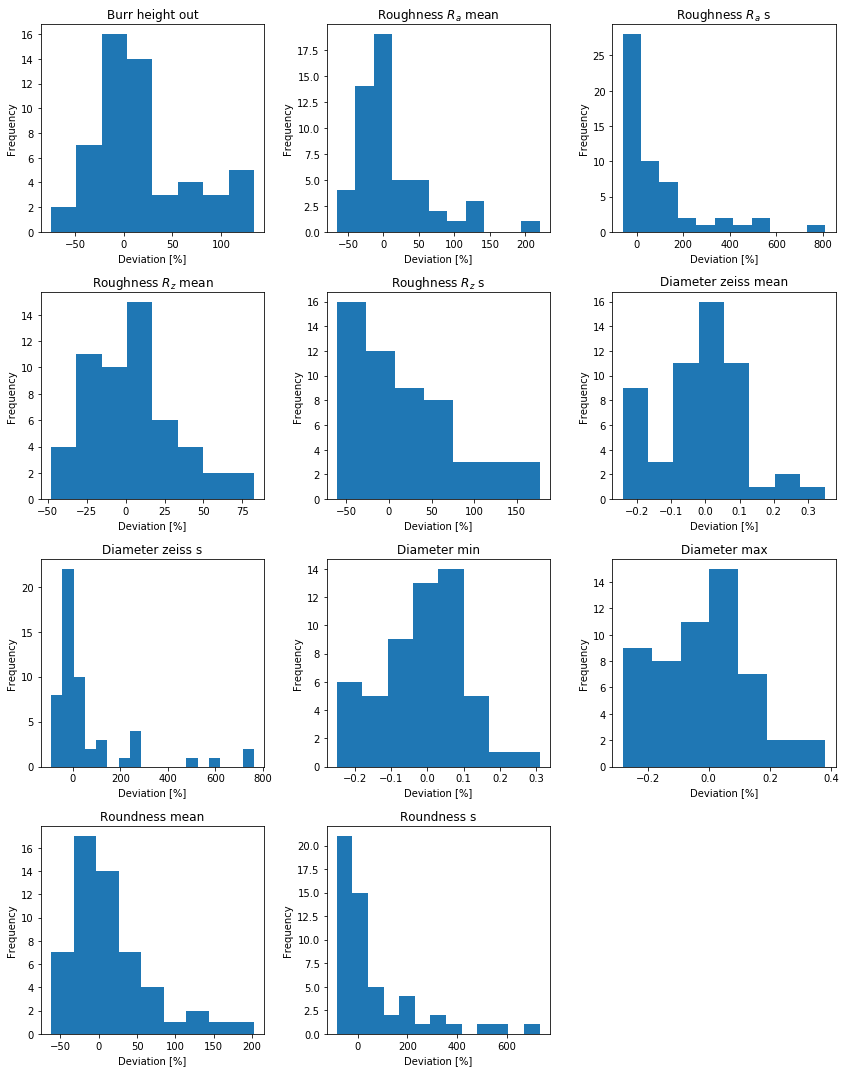

[0.4517614  0.25967771 0.05925191 0.18752962 0.10099408 0.75367009
 0.43748124 0.76326963 0.75631241 0.47678786 0.45040673]


In [11]:
# for split up statistical data
# create model
model_spl = build_model(Xspl_train, yspl_train)
if save_model_fig==True:
    plot_model(model_spl, to_file='C:/Users/nicol/OneDrive/Dokumente/Universitaet/Bachelorarbeit/novoid-LaTeX-KOMA-template-59a93cd/figures//model_spl.png', show_shapes=True, show_layer_names=True)


# train model
early_stop_spl = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history_spl = model_spl.fit(
    Xspl_train, yspl_train,
    epochs=num_epochs, validation_split = val_size, verbose=0, callbacks=[early_stop_spl])
#, validation_data=(Xspl_val, yspl_val)

# record history in a dataframe
hist_spl = pd.DataFrame(history_spl.history)
hist_spl['epoch'] = history_spl.epoch


# plot history
plot_history(history_spl, stat_type='spl'+saving_addendum)


# evaluate on the test set
yspl_pred = model_spl.predict(Xspl_test)
# print (spl_cols)
# print (splData.tail())
# print (spl_array[:5,:])
# print (yspl_pred[:5,:])
# print (yspl_test[:5,:])
# print (np.shape(yspl_test))


# mse for test set
loss_spl, mae_spl, mse_spl = model_spl.evaluate(Xspl_test, yspl_test, verbose=0)

print("Testing set Mean Square Error: {}".format(mse_spl))


# plot real and predicted labels for simple statistical data
yspl_testnn = rev_scaling(scaler_yspl, yspl_test)
yspl_prednn = rev_scaling(scaler_yspl, yspl_pred)
plot_labels(spl_array, yspl_testnn, yspl_prednn, stat_type='spl'+saving_addendum)


# plot histograms
hist_accuracy(spl_array, yspl_testnn, yspl_prednn, stat_type='spl'+saving_addendum)

# calculate r2 scores
R2_spl = r2_score(y_true=yspl_testnn, y_pred=yspl_prednn, multioutput='raw_values')
print (R2_spl)


# write both r2 scores to csv
if (save_fig == True) and (saving_addendum == ''):
    num_labels = np.shape(ysst_train)[1]
    label_names_old = sst_cols[-num_labels:]
    label_names = []
    for title in label_names_old:
        string = title.replace('_', ' ').capitalize().replace('ra', '$R_a$').replace('rz', '$R_z$')
        label_names.append(string)
    R2_sst_list = R2_sst.tolist()
    R2_spl_list = R2_spl.tolist()
    R2_df = pd.DataFrame({'Quality feature': label_names, 
                          '$R^2$ score complete TTS': R2_sst_list,
                          '$R^2$ score split TTS': R2_spl_list})
    print (R2_df)
    R2_df.to_csv(name_figures_dir +'//'+ 'R2scores.csv', index=False, float_format='%.4f')



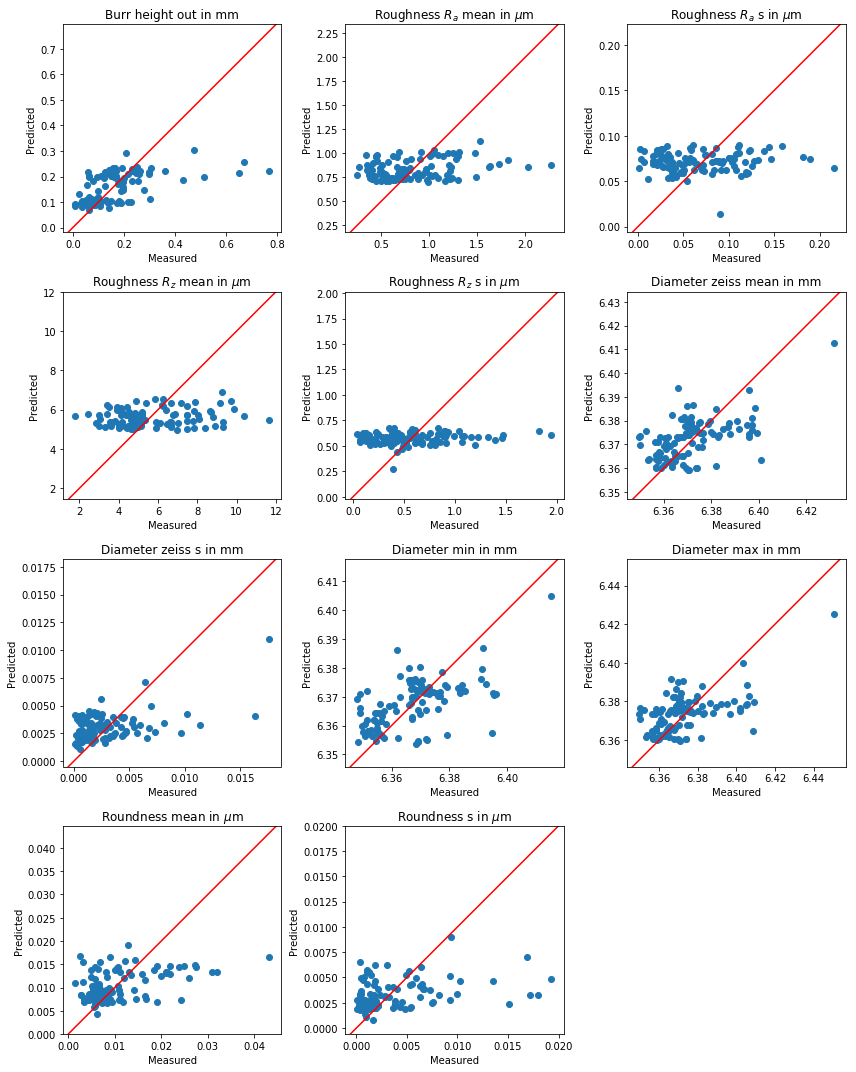

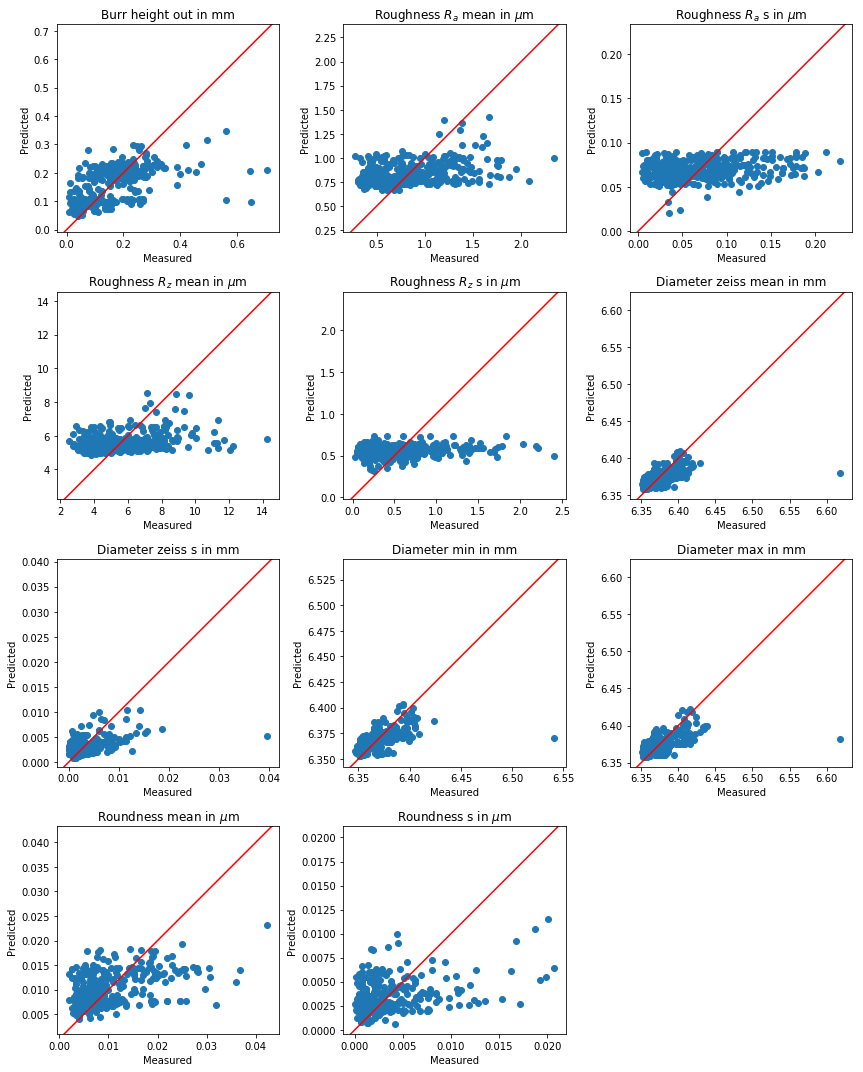

In [12]:
# check the networks predictions for the validation and training set
ysst_pred_val = model_sst.predict(Xsst_val)
# plot real and pred_validation labels for simple statistical data
ysst_valnn = rev_scaling(scaler_ysst, ysst_val)
ysst_pred_valnn = rev_scaling(scaler_ysst, ysst_pred_val)
plot_labels(sst_array, ysst_valnn, ysst_pred_valnn, stat_type='sst_val')


# training set
ysst_pred_train = model_sst.predict(Xsst_train)
# plot real and pred_trainicted labels for simple statistical data
ysst_trainnn = rev_scaling(scaler_ysst, ysst_train)
ysst_pred_trainnn = rev_scaling(scaler_ysst, ysst_pred_train)
plot_labels(sst_array, ysst_trainnn, ysst_pred_trainnn, stat_type='sst_train')